In [1]:
import pandas as pd
import pydicom as dicom
from PIL import Image
import numpy as np
import os
import cv2
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def get_patient_dictionary(path_to_patient_folder):
    """
    
    Returns dict of different types of images in the folder of patient. 
    
    Returns:
        dict: key - type of images; value - list of DICOM files, which sorted in the ascending order with restepct to the
                    depth of the image slice.
    """
    patient_dict = {}
    
    dicom_file_names = os.listdir(path_to_patient_folder)
    
    for i in range(len(dicom_file_names)):
        cur_dicom_obj = dicom.dcmread(os.path.join(path_to_patient_folder, dicom_file_names[i]))
        
        if cur_dicom_obj.SeriesDescription not in patient_dict.keys():
            patient_dict[cur_dicom_obj.SeriesDescription] = []
        patient_dict[cur_dicom_obj.SeriesDescription].append(cur_dicom_obj)
        
    # sort each type of images with respect to their depth in ascending order
    for i in patient_dict:
        patient_dict[i].sort(key=lambda x: x.InstanceNumber)
    
    return patient_dict

def get_pixels_hu(list_of_imgs):
    """
    Convert stack of the images into Houndsfeld units
    """
    image = np.stack([s.pixel_array for s in list_of_imgs])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = list_of_imgs[0].RescaleIntercept
    slope = list_of_imgs[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def show_stack(list_of_imgs, rows=6, cols=6, start_with=10, show_every=3):
    """
    Show stack of the images with the given parameters.
    """
    fig,ax = plt.subplots(rows,cols,figsize=[20,20])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(list_of_imgs[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()





### Read One Patient

In [7]:
dataset_path = '/home/marichka/Documents/CardioVision/ONLY_MPR'
all_patients = os.listdir(dataset_path)
len(all_patients)

743

In [8]:
path_to_the_patient = os.path.join(dataset_path, all_patients[0])
pat_dict = get_patient_dictionary(path_to_the_patient)

### Print all keys in the current patient

In [7]:
pat_dict.keys()

dict_keys(['LCX-OM*', 'RCA-AM*', 'RCA-PDA*', 'RCA-PLB*', 'AW electronic film', 'Scout', 'CALCIUM SCORE', 'CTCA SMARTPHASE', 'LAD*', 'LAD-D1*', 'LAD-D2*', 'LCX*'])

In [8]:
for key in pat_dict:
    print(key)

LCX-OM*
RCA-AM*
RCA-PDA*
RCA-PLB*
AW electronic film
Scout
CALCIUM SCORE
CTCA SMARTPHASE
LAD*
LAD-D1*
LAD-D2*
LCX*


### Example of getting the image

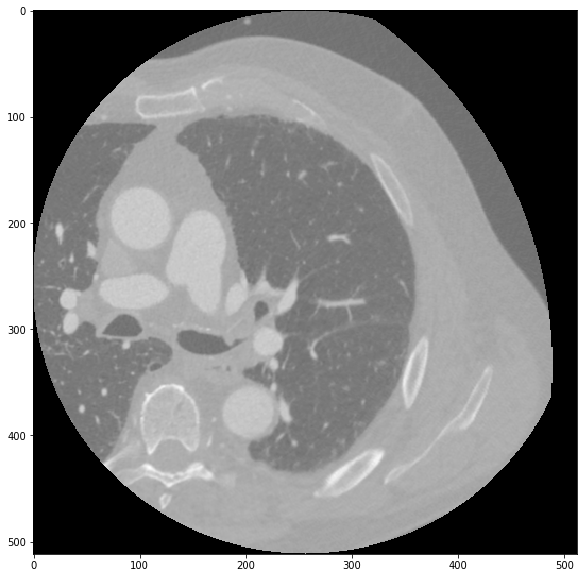

In [9]:
dicom_file = pat_dict['CTCA SMARTPHASE'][10]# we take DICOM file of the 10th slice in calcium score section
img = dicom_file.pixel_array

plt.figure(figsize=(10,10))
plt.imshow(img, 'gray')

### Convert to Hounsfield Units

The unit of measurement in CT scans is the Hounsfield Unit (HU), which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this. By <b>default</b> the returned values are not in this unit.  We convert to the HU range by multiplying with the rescale slope and adding the intercept (which are conveniently stored in the metadata of the scans!)
![title](hu_range.png)


In [10]:
converted_to_hu_images = get_pixels_hu(pat_dict['CTCA SMARTPHASE'])

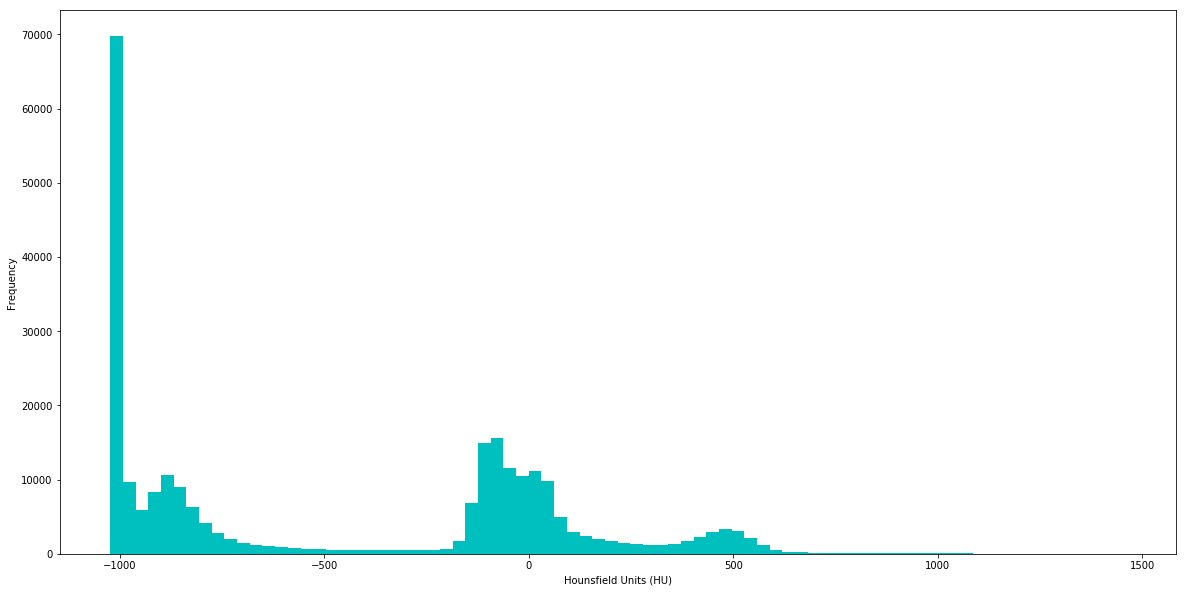

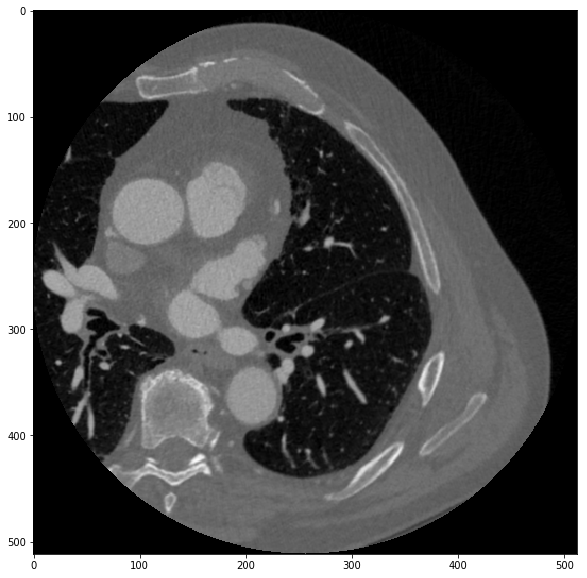

In [11]:
plt.figure(figsize=(20,10))
plt.hist(converted_to_hu_images[50].flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")

plt.figure(figsize=(10,10))
plt.imshow(converted_to_hu_images[50], 'gray')

In [16]:
cv2.imwrite('lol1.png',pat_dict['CTCA SMARTPHASE'][50].pixel_array)

True

### Show stack of the images(RCA-PDA)

In [ ]:
show_stack(converted_to_hu_images, rows=4, cols=4, start_with=1, show_every=3)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(converted_to_hu_images[0], 'gray')

### Number of Images over all patients with the records and MPR reconstruction

In [3]:
path_to_the_patients = r"..\dataset\ctca_with_recons_excel_reports_321-350"

patients_folder_names = os.listdir(path_to_the_patients)

In [33]:
dict_with_types_of_images = dict()

for i in tqdm(range(len(patients_folder_names))):
    cur_pat_dict = get_patient_dictionary(os.path.join(path_to_the_patients, patients_folder_names[i], 'images'))
    for key in cur_pat_dict:
        if key not in dict_with_types_of_images.keys():
            lol = np.zeros((512,512))
            kik = cur_pat_dict[key][0].pixel_array
            
            cv2.imwrite('images/' + key + '.png',  cv2.normalize(kik,lol, 0,255,cv2.NORM_MINMAX ))
            dict_with_types_of_images[key] = 0
        dict_with_types_of_images[key]+= len(cur_pat_dict[key])



100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [05:42<00:00, 16.18s/it]

In [ ]:
for key in dict_with_types_of_images:
    print(key, dict_with_types_of_images[key])

In [5]:

def get_striped_record(path_to_record):
    '''
    Read record file and remove empty rows and rows with all NaNs.
    '''
    excel_file = pd.read_excel(path_to_record,index_col=None, header=None)
    excel_file.dropna(how='all')
    excel_file.rename(columns={0: 'a', 1: 'b'}, inplace=True)
    excel_file = excel_file.fillna('  ')
    excel_file = excel_file.replace('', '  ', regex=True)
    excel_file = excel_file.drop(excel_file[excel_file['a'].str.isspace()].index)
    return excel_file


In [6]:
patient = get_patient_dictionary(r'D:\coronaryProject\dataset\binary_classification_MPR\images\1015 CTCA1967')

In [6]:
patient.keys()

dict_keys(['OM *', 'OM2 *', 'RIB *', 'RCA *', 'RCA-PDA *', 'LAD *', 'LAD-D1 *', 'LAD-D2 *'])

In [8]:
excel_file = get_striped_record(r'D:\coronaryProject\dataset\binary_classification_MPR\reports\REPORT 1015 CTCA1967.xlsx')

In [9]:
excel_file

,a,b
0,ID:,1015 CTCA1967
1,DOB:,1967
2,Age/Gender:,"51Y, M"
3,Procedure:,CT SCAN-CHEST
4,Accession #:,
5,Report Status:,Finalized
6,Reason:,CT CORONARY ANGIOGRAM
7,Impression:,
11,CT CORONARY ANGIOGRAM & CALCIUM SCORE:,
12,Clinical Notes: 1 Episode of chest pain 2 we...,


In [15]:
path_to_patients = r'D:\coronaryProject\dataset\binary_classification_MPR\images'
patients = os.listdir(path_to_patients)

In [24]:
lad_num = 0
unique = list()
for i in tqdm(range(len(patients))):
    print(lad_num)
    cur_pat = get_patient_dictionary(os.path.join(path_to_patients, patients[i]))
    for key in cur_pat.keys():
        if 'LAD' in key or 'lad' in key.lower():
            lad_num+= len(cur_pat[key])
            if key not in unique:
                unique.append(key)
#                 print(unique)



  0%|                                                                                          | 0/744 [00:00<?, ?it/s]

0
['LAD-D1 *']
['LAD-D1 *', 'LAD *']




  0%|                                                                                | 1/744 [00:18<3:54:18, 18.92s/it]

100
['LAD-D1 *', 'LAD *', 'LAD-D2 *']




  0%|▏                                                                               | 2/744 [00:28<3:18:19, 16.04s/it]

250




  0%|▎                                                                               | 3/744 [00:34<2:43:30, 13.24s/it]

350
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *']




  1%|▍                                                                               | 4/744 [00:49<2:48:55, 13.70s/it]

550




  1%|▌                                                                               | 5/744 [00:58<2:30:34, 12.23s/it]

700




  1%|▋                                                                               | 6/744 [01:05<2:11:41, 10.71s/it]

800




  1%|▊                                                                               | 7/744 [01:11<1:53:09,  9.21s/it]

900




  1%|▊                                                                               | 8/744 [01:16<1:39:00,  8.07s/it]

1050




  1%|▉                                                                               | 9/744 [01:21<1:26:45,  7.08s/it]

1150




  1%|█                                                                              | 10/744 [01:31<1:38:24,  8.04s/it]

1300




  1%|█▏                                                                             | 11/744 [01:53<2:27:38, 12.09s/it]

1400




  2%|█▎                                                                             | 12/744 [02:10<2:47:23, 13.72s/it]

1500




  2%|█▍                                                                             | 13/744 [02:26<2:55:29, 14.40s/it]

1650




  2%|█▍                                                                             | 14/744 [02:38<2:43:54, 13.47s/it]

1800




  2%|█▌                                                                             | 15/744 [02:54<2:54:39, 14.38s/it]

1850




  2%|█▋                                                                             | 16/744 [03:09<2:56:03, 14.51s/it]

2000




  2%|█▊                                                                             | 17/744 [03:16<2:28:48, 12.28s/it]

2100




  2%|█▉                                                                             | 18/744 [03:26<2:19:45, 11.55s/it]

2200




  3%|██                                                                             | 19/744 [03:34<2:07:26, 10.55s/it]

2350




  3%|██                                                                             | 20/744 [03:43<2:00:46, 10.01s/it]

2450




  3%|██▏                                                                            | 21/744 [03:54<2:04:24, 10.32s/it]

2550




  3%|██▎                                                                            | 22/744 [04:09<2:20:53, 11.71s/it]

2700




  3%|██▍                                                                            | 23/744 [04:20<2:18:59, 11.57s/it]

2850




  3%|██▌                                                                            | 24/744 [04:36<2:35:09, 12.93s/it]

2950




  3%|██▋                                                                            | 25/744 [04:47<2:25:24, 12.13s/it]

3100




  3%|██▊                                                                            | 26/744 [04:58<2:22:21, 11.90s/it]

3300




  4%|██▊                                                                            | 27/744 [05:07<2:11:25, 11.00s/it]

3450




  4%|██▉                                                                            | 28/744 [05:23<2:31:35, 12.70s/it]

3600




  4%|███                                                                            | 29/744 [05:35<2:26:53, 12.33s/it]

3700




  4%|███▏                                                                           | 30/744 [05:56<2:57:08, 14.89s/it]

3800




  4%|███▎                                                                           | 31/744 [06:05<2:36:29, 13.17s/it]

3900




  4%|███▍                                                                           | 32/744 [06:16<2:29:35, 12.61s/it]

4000




  4%|███▌                                                                           | 33/744 [06:24<2:11:54, 11.13s/it]

4100




  5%|███▌                                                                           | 34/744 [06:37<2:19:11, 11.76s/it]

4300




  5%|███▋                                                                           | 35/744 [06:46<2:08:19, 10.86s/it]

4350




  5%|███▊                                                                           | 36/744 [07:04<2:33:34, 13.01s/it]

4500




  5%|███▉                                                                           | 37/744 [07:19<2:39:23, 13.53s/it]

4650




  5%|████                                                                           | 38/744 [07:35<2:47:46, 14.26s/it]

4800




  5%|████▏                                                                          | 39/744 [07:44<2:31:32, 12.90s/it]

4900




  5%|████▏                                                                          | 40/744 [07:56<2:27:23, 12.56s/it]

4950




  6%|████▎                                                                          | 41/744 [08:05<2:15:09, 11.54s/it]

5050




  6%|████▍                                                                          | 42/744 [08:12<1:58:50, 10.16s/it]

5150




  6%|████▌                                                                          | 43/744 [08:26<2:09:57, 11.12s/it]

5300
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *']




  6%|████▋                                                                          | 44/744 [08:40<2:20:26, 12.04s/it]

5550




  6%|████▊                                                                          | 45/744 [08:54<2:28:30, 12.75s/it]

5700




  6%|████▉                                                                          | 46/744 [09:10<2:40:12, 13.77s/it]

5800




  6%|████▉                                                                          | 47/744 [09:22<2:32:44, 13.15s/it]

5950




  6%|█████                                                                          | 48/744 [09:34<2:28:43, 12.82s/it]

6100




  7%|█████▏                                                                         | 49/744 [09:45<2:21:00, 12.17s/it]

6200




  7%|█████▎                                                                         | 50/744 [09:52<2:04:42, 10.78s/it]

6350




  7%|█████▍                                                                         | 51/744 [10:07<2:17:33, 11.91s/it]

6550




  7%|█████▌                                                                         | 52/744 [10:15<2:05:33, 10.89s/it]

6700




  7%|█████▋                                                                         | 53/744 [10:23<1:55:38, 10.04s/it]

6800
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD']
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1']
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2']




  7%|█████▋                                                                         | 54/744 [10:35<1:59:53, 10.43s/it]

6950




  7%|█████▊                                                                         | 55/744 [10:51<2:20:44, 12.26s/it]

7100




  8%|█████▉                                                                         | 56/744 [11:01<2:12:00, 11.51s/it]

7250




  8%|██████                                                                         | 57/744 [11:12<2:11:22, 11.47s/it]

7350
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*']
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*']




  8%|██████▏                                                                        | 58/744 [11:21<2:00:43, 10.56s/it]

7450




  8%|██████▎                                                                        | 59/744 [11:31<1:58:28, 10.38s/it]

7550




  8%|██████▎                                                                        | 60/744 [11:41<1:58:55, 10.43s/it]

7650




  8%|██████▍                                                                        | 61/744 [11:55<2:09:08, 11.35s/it]

7800




  8%|██████▌                                                                        | 62/744 [12:08<2:13:53, 11.78s/it]

7900




  8%|██████▋                                                                        | 63/744 [12:18<2:09:33, 11.41s/it]

8050




  9%|██████▊                                                                        | 64/744 [12:32<2:17:14, 12.11s/it]

8150




  9%|██████▉                                                                        | 65/744 [12:48<2:30:51, 13.33s/it]

8350




  9%|███████                                                                        | 66/744 [12:59<2:23:33, 12.70s/it]

8450




  9%|███████                                                                        | 67/744 [13:16<2:37:48, 13.99s/it]

8600




  9%|███████▏                                                                       | 68/744 [13:28<2:30:03, 13.32s/it]

8750




  9%|███████▎                                                                       | 69/744 [13:39<2:20:32, 12.49s/it]

8900




  9%|███████▍                                                                       | 70/744 [13:48<2:11:28, 11.70s/it]

9050




 10%|███████▌                                                                       | 71/744 [13:59<2:06:30, 11.28s/it]

9150
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*', 'LAD-D2*']




 10%|███████▋                                                                       | 72/744 [14:15<2:21:57, 12.68s/it]

9300
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*', 'LAD-D2*', 'LAD - D1']




 10%|███████▊                                                                       | 73/744 [14:26<2:17:06, 12.26s/it]

9400




 10%|███████▊                                                                       | 74/744 [14:37<2:11:54, 11.81s/it]

9500




 10%|███████▉                                                                       | 75/744 [14:47<2:06:25, 11.34s/it]

9600




 10%|████████                                                                       | 76/744 [15:00<2:10:19, 11.71s/it]

9750




 10%|████████▏                                                                      | 77/744 [15:14<2:19:18, 12.53s/it]

9900




 10%|████████▎                                                                      | 78/744 [15:35<2:47:18, 15.07s/it]

10050




 11%|████████▍                                                                      | 79/744 [15:51<2:49:20, 15.28s/it]

10150




 11%|████████▍                                                                      | 80/744 [16:09<2:58:40, 16.15s/it]

10300




 11%|████████▌                                                                      | 81/744 [16:19<2:38:15, 14.32s/it]

10400




 11%|████████▋                                                                      | 82/744 [16:27<2:15:46, 12.31s/it]

10500




 11%|████████▊                                                                      | 83/744 [16:34<1:57:57, 10.71s/it]

10600
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*', 'LAD-D2*', 'LAD - D1', 'LAD-D3']




 11%|████████▉                                                                      | 84/744 [16:40<1:44:05,  9.46s/it]

10700




 11%|█████████                                                                      | 85/744 [16:55<2:01:16, 11.04s/it]

10800




 12%|█████████▏                                                                     | 86/744 [17:05<1:57:35, 10.72s/it]

10900




 12%|█████████▏                                                                     | 87/744 [17:17<2:02:53, 11.22s/it]

11050




 12%|█████████▎                                                                     | 88/744 [17:29<2:06:03, 11.53s/it]

11200




 12%|█████████▍                                                                     | 89/744 [17:38<1:57:29, 10.76s/it]

11300




 12%|█████████▌                                                                     | 90/744 [17:48<1:54:29, 10.50s/it]

11450




 12%|█████████▋                                                                     | 91/744 [17:59<1:54:36, 10.53s/it]

11600




 12%|█████████▊                                                                     | 92/744 [18:09<1:52:16, 10.33s/it]

11700




 12%|█████████▉                                                                     | 93/744 [18:22<2:02:03, 11.25s/it]

11850




 13%|█████████▉                                                                     | 94/744 [18:33<2:01:43, 11.24s/it]

11950




 13%|██████████                                                                     | 95/744 [18:44<2:00:03, 11.10s/it]

12100




 13%|██████████▏                                                                    | 96/744 [18:53<1:51:35, 10.33s/it]

12200




 13%|██████████▎                                                                    | 97/744 [19:09<2:09:36, 12.02s/it]

12250




 13%|██████████▍                                                                    | 98/744 [19:22<2:14:16, 12.47s/it]

12400




 13%|██████████▌                                                                    | 99/744 [19:35<2:16:08, 12.66s/it]

12600




 13%|██████████▍                                                                   | 100/744 [19:45<2:07:21, 11.87s/it]

12650




 14%|██████████▌                                                                   | 101/744 [19:53<1:54:12, 10.66s/it]

12800




 14%|██████████▋                                                                   | 102/744 [20:06<2:01:01, 11.31s/it]

12950




 14%|██████████▊                                                                   | 103/744 [20:17<1:59:12, 11.16s/it]

13100




 14%|██████████▉                                                                   | 104/744 [20:29<2:03:21, 11.56s/it]

13250




 14%|███████████                                                                   | 105/744 [20:39<1:57:15, 11.01s/it]

13400
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*', 'LAD-D2*', 'LAD - D1', 'LAD-D3', 'LIMA-LAD']
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*', 'LAD-D2*', 'LAD - D1', 'LAD-D3', 'LIMA-LAD', 'LAD original']
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*', 'LAD-D2*', 'LAD - D1', 'LAD-D3', 'LIMA-LAD', 'LAD original', 'LAD-D1 original']




 14%|███████████                                                                   | 106/744 [20:54<2:08:59, 12.13s/it]

13550




 14%|███████████▏                                                                  | 107/744 [21:05<2:05:36, 11.83s/it]

13700




 15%|███████████▎                                                                  | 108/744 [21:14<1:57:21, 11.07s/it]

13850




 15%|███████████▍                                                                  | 109/744 [21:24<1:53:36, 10.73s/it]

13950




 15%|███████████▌                                                                  | 110/744 [21:34<1:49:42, 10.38s/it]

14100




 15%|███████████▋                                                                  | 111/744 [21:40<1:36:25,  9.14s/it]

14200




 15%|███████████▋                                                                  | 112/744 [21:51<1:40:51,  9.57s/it]

14300
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*', 'LAD-D2*', 'LAD - D1', 'LAD-D3', 'LIMA-LAD', 'LAD original', 'LAD-D1 original', 'LAD-D2 original']
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*', 'LAD-D2*', 'LAD - D1', 'LAD-D3', 'LIMA-LAD', 'LAD original', 'LAD-D1 original', 'LAD-D2 original', 'LAD-D3 original']
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*', 'LAD-D2*', 'LAD - D1', 'LAD-D3', 'LIMA-LAD', 'LAD original', 'LAD-D1 original', 'LAD-D2 original', 'LAD-D3 original', 'LIMA-LAD graft']




 15%|███████████▊                                                                  | 113/744 [22:07<2:03:39, 11.76s/it]

14550




 15%|███████████▉                                                                  | 114/744 [22:21<2:10:05, 12.39s/it]

14700




 15%|████████████                                                                  | 115/744 [22:34<2:09:55, 12.39s/it]

14900




 16%|████████████▏                                                                 | 116/744 [22:48<2:14:58, 12.90s/it]

15100




 16%|████████████▎                                                                 | 117/744 [22:56<2:01:45, 11.65s/it]

15200




 16%|████████████▎                                                                 | 118/744 [23:07<1:56:36, 11.18s/it]

15350




 16%|████████████▍                                                                 | 119/744 [23:17<1:55:16, 11.07s/it]

15450




 16%|████████████▌                                                                 | 120/744 [23:30<1:58:43, 11.42s/it]

15650
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*', 'LAD-D2*', 'LAD - D1', 'LAD-D3', 'LIMA-LAD', 'LAD original', 'LAD-D1 original', 'LAD-D2 original', 'LAD-D3 original', 'LIMA-LAD graft', 'LAD-Branch of D1']




 16%|████████████▋                                                                 | 121/744 [23:38<1:50:39, 10.66s/it]

15800




 16%|████████████▊                                                                 | 122/744 [23:53<2:02:12, 11.79s/it]

15950




 17%|████████████▉                                                                 | 123/744 [24:11<2:22:23, 13.76s/it]

16100




 17%|█████████████                                                                 | 124/744 [24:19<2:04:55, 12.09s/it]

16200




 17%|█████████████                                                                 | 125/744 [24:32<2:05:06, 12.13s/it]

16350




 17%|█████████████▏                                                                | 126/744 [24:47<2:14:29, 13.06s/it]

16500




 17%|█████████████▎                                                                | 127/744 [24:59<2:11:34, 12.79s/it]

16600




 17%|█████████████▍                                                                | 128/744 [25:13<2:15:31, 13.20s/it]

16750




 17%|█████████████▌                                                                | 129/744 [25:29<2:24:13, 14.07s/it]

16950




 17%|█████████████▋                                                                | 130/744 [25:40<2:12:51, 12.98s/it]

17050




 18%|█████████████▋                                                                | 131/744 [25:51<2:07:42, 12.50s/it]

17150




 18%|█████████████▊                                                                | 132/744 [26:01<1:59:08, 11.68s/it]

17250




 18%|█████████████▉                                                                | 133/744 [26:13<2:00:21, 11.82s/it]

17450




 18%|██████████████                                                                | 134/744 [26:25<1:59:33, 11.76s/it]

17550
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*', 'LAD-D2*', 'LAD - D1', 'LAD-D3', 'LIMA-LAD', 'LAD original', 'LAD-D1 original', 'LAD-D2 original', 'LAD-D3 original', 'LIMA-LAD graft', 'LAD-Branch of D1', 'LAD-D4']




 18%|██████████████▏                                                               | 135/744 [26:39<2:08:36, 12.67s/it]

17800




 18%|██████████████▎                                                               | 136/744 [26:53<2:10:35, 12.89s/it]

18000




 18%|██████████████▎                                                               | 137/744 [27:05<2:09:06, 12.76s/it]

18150




 19%|██████████████▍                                                               | 138/744 [27:13<1:54:09, 11.30s/it]

18300




 19%|██████████████▌                                                               | 139/744 [27:24<1:52:57, 11.20s/it]

18400




 19%|██████████████▋                                                               | 140/744 [27:35<1:51:46, 11.10s/it]

18500




 19%|██████████████▊                                                               | 141/744 [27:46<1:50:52, 11.03s/it]

18650




 19%|██████████████▉                                                               | 142/744 [28:00<1:59:12, 11.88s/it]

18800




 19%|██████████████▉                                                               | 143/744 [28:15<2:10:02, 12.98s/it]

18950




 19%|███████████████                                                               | 144/744 [28:25<1:59:48, 11.98s/it]

19100




 19%|███████████████▏                                                              | 145/744 [28:34<1:49:20, 10.95s/it]

19200




 20%|███████████████▎                                                              | 146/744 [28:48<1:58:46, 11.92s/it]

19350




 20%|███████████████▍                                                              | 147/744 [29:00<1:58:19, 11.89s/it]

19550




 20%|███████████████▌                                                              | 148/744 [29:14<2:06:55, 12.78s/it]

19650




 20%|███████████████▌                                                              | 149/744 [29:24<1:56:38, 11.76s/it]

19750




 20%|███████████████▋                                                              | 150/744 [29:35<1:54:46, 11.59s/it]

19850




 20%|███████████████▊                                                              | 151/744 [29:48<1:58:49, 12.02s/it]

20050




 20%|███████████████▉                                                              | 152/744 [30:15<2:41:52, 16.41s/it]

20200




 21%|████████████████                                                              | 153/744 [30:27<2:30:30, 15.28s/it]

20350




 21%|████████████████▏                                                             | 154/744 [30:42<2:28:12, 15.07s/it]

20550




 21%|████████████████▎                                                             | 155/744 [30:49<2:05:12, 12.75s/it]

20650




 21%|████████████████▎                                                             | 156/744 [31:01<2:03:03, 12.56s/it]

20750




 21%|████████████████▍                                                             | 157/744 [31:12<1:56:18, 11.89s/it]

20800




 21%|████████████████▌                                                             | 158/744 [31:19<1:43:39, 10.61s/it]

20900




 21%|████████████████▋                                                             | 159/744 [31:31<1:47:04, 10.98s/it]

21050




 22%|████████████████▊                                                             | 160/744 [31:39<1:38:30, 10.12s/it]

21150




 22%|████████████████▉                                                             | 161/744 [31:50<1:39:16, 10.22s/it]

21300




 22%|████████████████▉                                                             | 162/744 [32:44<3:45:56, 23.29s/it]

21450




 22%|█████████████████                                                             | 163/744 [32:57<3:16:14, 20.27s/it]

21650




 22%|█████████████████▏                                                            | 164/744 [33:07<2:47:42, 17.35s/it]

21750




 22%|█████████████████▎                                                            | 165/744 [33:18<2:28:12, 15.36s/it]

21950




 22%|█████████████████▍                                                            | 166/744 [33:26<2:05:36, 13.04s/it]

22050




 22%|█████████████████▌                                                            | 167/744 [33:43<2:16:49, 14.23s/it]

22250




 23%|█████████████████▌                                                            | 168/744 [33:52<2:01:25, 12.65s/it]

22350




 23%|█████████████████▋                                                            | 169/744 [34:06<2:07:00, 13.25s/it]

22450




 23%|█████████████████▊                                                            | 170/744 [34:24<2:19:51, 14.62s/it]

22700




 23%|█████████████████▉                                                            | 171/744 [34:41<2:26:14, 15.31s/it]

22950




 23%|██████████████████                                                            | 172/744 [34:54<2:20:43, 14.76s/it]

23050




 23%|██████████████████▏                                                           | 173/744 [35:16<2:41:06, 16.93s/it]

23150




 23%|██████████████████▏                                                           | 174/744 [35:38<2:54:56, 18.41s/it]

23300




 24%|██████████████████▎                                                           | 175/744 [36:02<3:10:11, 20.06s/it]

23400




 24%|██████████████████▍                                                           | 176/744 [37:17<5:45:25, 36.49s/it]

23500




 24%|██████████████████▌                                                           | 177/744 [37:31<4:41:42, 29.81s/it]

23650




 24%|██████████████████▋                                                           | 178/744 [37:46<3:58:34, 25.29s/it]

23850
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*', 'LAD-D2*', 'LAD - D1', 'LAD-D3', 'LIMA-LAD', 'LAD original', 'LAD-D1 original', 'LAD-D2 original', 'LAD-D3 original', 'LIMA-LAD graft', 'LAD-Branch of D1', 'LAD-D4', 'LAD Original']
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*', 'LAD-D2*', 'LAD - D1', 'LAD-D3', 'LIMA-LAD', 'LAD original', 'LAD-D1 original', 'LAD-D2 original', 'LAD-D3 original', 'LIMA-LAD graft', 'LAD-Branch of D1', 'LAD-D4', 'LAD Original', 'LAD-D1 Original']
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*', 'LAD-D2*', 'LAD - D1', 'LAD-D3', 'LIMA-LAD', 'LAD original', 'LAD-D1 original', 'LAD-D2 original', 'LAD-D3 original', 'LIMA-LAD graft', 'LAD-Branch of D1', 'LAD-D4', 'LAD Original', 'LAD-D1 Original', 'Aorta-LAD graft']




 24%|██████████████████▊                                                           | 179/744 [38:06<3:42:00, 23.58s/it]

24000




 24%|██████████████████▊                                                           | 180/744 [38:20<3:15:38, 20.81s/it]

24150




 24%|██████████████████▉                                                           | 181/744 [38:36<3:01:21, 19.33s/it]

24250




 24%|███████████████████                                                           | 182/744 [38:53<2:54:06, 18.59s/it]

24400




 25%|███████████████████▏                                                          | 183/744 [39:17<3:09:31, 20.27s/it]

24600




 25%|███████████████████▎                                                          | 184/744 [39:33<2:57:52, 19.06s/it]

24750




 25%|███████████████████▍                                                          | 185/744 [39:51<2:55:32, 18.84s/it]

24900




 25%|███████████████████▌                                                          | 186/744 [40:05<2:41:15, 17.34s/it]

25000




 25%|███████████████████▌                                                          | 187/744 [40:31<3:05:03, 19.93s/it]

25200




 25%|███████████████████▋                                                          | 188/744 [40:47<2:53:01, 18.67s/it]

25300




 25%|███████████████████▊                                                          | 189/744 [40:57<2:27:34, 15.95s/it]

25400




 26%|███████████████████▉                                                          | 190/744 [41:09<2:16:47, 14.82s/it]

25550




 26%|████████████████████                                                          | 191/744 [41:25<2:19:31, 15.14s/it]

25700




 26%|████████████████████▏                                                         | 192/744 [41:38<2:15:46, 14.76s/it]

25800




 26%|████████████████████▏                                                         | 193/744 [41:51<2:10:30, 14.21s/it]

25900




 26%|████████████████████▎                                                         | 194/744 [42:05<2:08:03, 13.97s/it]

26000




 26%|████████████████████▍                                                         | 195/744 [42:32<2:43:39, 17.89s/it]

26150




 26%|████████████████████▌                                                         | 196/744 [42:52<2:49:50, 18.60s/it]

26350




 26%|████████████████████▋                                                         | 197/744 [43:09<2:45:39, 18.17s/it]

26500




 27%|████████████████████▊                                                         | 198/744 [43:26<2:41:57, 17.80s/it]

26600




 27%|████████████████████▊                                                         | 199/744 [43:44<2:41:21, 17.76s/it]

26750




 27%|████████████████████▉                                                         | 200/744 [44:16<3:19:50, 22.04s/it]

26900




 27%|█████████████████████                                                         | 201/744 [44:34<3:08:21, 20.81s/it]

27050




 27%|█████████████████████▏                                                        | 202/744 [44:51<2:59:12, 19.84s/it]

27200




 27%|█████████████████████▎                                                        | 203/744 [45:07<2:48:03, 18.64s/it]

27350




 27%|█████████████████████▍                                                        | 204/744 [45:23<2:39:59, 17.78s/it]

27500




 28%|█████████████████████▍                                                        | 205/744 [46:03<3:38:20, 24.31s/it]

27700




 28%|█████████████████████▌                                                        | 206/744 [46:46<4:29:27, 30.05s/it]

27900




 28%|█████████████████████▋                                                        | 207/744 [47:23<4:47:27, 32.12s/it]

28100




 28%|█████████████████████▊                                                        | 208/744 [47:34<3:50:53, 25.85s/it]

28200




 28%|█████████████████████▉                                                        | 209/744 [47:57<3:41:00, 24.79s/it]

28300




 28%|██████████████████████                                                        | 210/744 [48:09<3:07:11, 21.03s/it]

28450




 28%|██████████████████████                                                        | 211/744 [48:25<2:54:30, 19.64s/it]

28550




 28%|██████████████████████▏                                                       | 212/744 [48:44<2:51:44, 19.37s/it]

28700




 29%|██████████████████████▎                                                       | 213/744 [49:00<2:42:26, 18.35s/it]

28850




 29%|██████████████████████▍                                                       | 214/744 [49:26<3:02:05, 20.61s/it]

29050




 29%|██████████████████████▌                                                       | 215/744 [49:55<3:25:36, 23.32s/it]

29300




 29%|██████████████████████▋                                                       | 216/744 [50:13<3:09:27, 21.53s/it]

29450




 29%|██████████████████████▊                                                       | 217/744 [50:33<3:05:16, 21.09s/it]

29650




 29%|██████████████████████▊                                                       | 218/744 [51:02<3:27:16, 23.64s/it]

29800




 29%|██████████████████████▉                                                       | 219/744 [51:18<3:06:35, 21.32s/it]

29900




 30%|███████████████████████                                                       | 220/744 [51:34<2:50:23, 19.51s/it]

30000




 30%|███████████████████████▏                                                      | 221/744 [51:48<2:37:25, 18.06s/it]

30150




 30%|███████████████████████▎                                                      | 222/744 [52:02<2:25:59, 16.78s/it]

30250




 30%|███████████████████████▍                                                      | 223/744 [52:14<2:11:57, 15.20s/it]

30300




 30%|███████████████████████▍                                                      | 224/744 [52:28<2:10:30, 15.06s/it]

30450




 30%|███████████████████████▌                                                      | 225/744 [52:44<2:11:30, 15.20s/it]

30600




 30%|███████████████████████▋                                                      | 226/744 [52:58<2:09:29, 15.00s/it]

30700
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*', 'LAD-D2*', 'LAD - D1', 'LAD-D3', 'LIMA-LAD', 'LAD original', 'LAD-D1 original', 'LAD-D2 original', 'LAD-D3 original', 'LIMA-LAD graft', 'LAD-Branch of D1', 'LAD-D4', 'LAD Original', 'LAD-D1 Original', 'Aorta-LAD graft', 'LAD-D3*']




 31%|███████████████████████▊                                                      | 227/744 [53:17<2:17:54, 16.00s/it]

30900




 31%|███████████████████████▉                                                      | 228/744 [53:36<2:26:37, 17.05s/it]

31100




 31%|████████████████████████                                                      | 229/744 [53:53<2:24:44, 16.86s/it]

31250




 31%|████████████████████████                                                      | 230/744 [54:09<2:22:37, 16.65s/it]

31350




 31%|████████████████████████▏                                                     | 231/744 [54:23<2:16:58, 16.02s/it]

31500




 31%|████████████████████████▎                                                     | 232/744 [54:43<2:25:15, 17.02s/it]

31700




 31%|████████████████████████▍                                                     | 233/744 [54:55<2:13:03, 15.62s/it]

31800




 31%|████████████████████████▌                                                     | 234/744 [55:13<2:17:46, 16.21s/it]

31950




 32%|████████████████████████▋                                                     | 235/744 [55:27<2:13:15, 15.71s/it]

32050




 32%|████████████████████████▋                                                     | 236/744 [55:40<2:04:49, 14.74s/it]

32150




 32%|████████████████████████▊                                                     | 237/744 [55:57<2:10:41, 15.47s/it]

32300




 32%|████████████████████████▉                                                     | 238/744 [56:15<2:16:01, 16.13s/it]

32400




 32%|█████████████████████████                                                     | 239/744 [56:38<2:34:02, 18.30s/it]

32550




 32%|█████████████████████████▏                                                    | 240/744 [56:49<2:16:33, 16.26s/it]

32650




 32%|█████████████████████████▎                                                    | 241/744 [57:14<2:37:20, 18.77s/it]

32800




 33%|█████████████████████████▎                                                    | 242/744 [57:31<2:33:03, 18.29s/it]

32950




 33%|█████████████████████████▍                                                    | 243/744 [57:52<2:38:44, 19.01s/it]

33150




 33%|█████████████████████████▌                                                    | 244/744 [58:05<2:22:50, 17.14s/it]

33250




 33%|█████████████████████████▋                                                    | 245/744 [58:17<2:10:29, 15.69s/it]

33350




 33%|█████████████████████████▊                                                    | 246/744 [58:25<1:51:29, 13.43s/it]

33350




 33%|█████████████████████████▉                                                    | 247/744 [58:38<1:49:43, 13.25s/it]

33500




 33%|██████████████████████████                                                    | 248/744 [58:52<1:51:27, 13.48s/it]

33600




 33%|██████████████████████████                                                    | 249/744 [59:12<2:07:30, 15.46s/it]

33700




 34%|██████████████████████████▏                                                   | 250/744 [59:33<2:21:35, 17.20s/it]

33850




 34%|██████████████████████████▎                                                   | 251/744 [59:53<2:26:37, 17.85s/it]

34050




 34%|█████████████████████████▋                                                  | 252/744 [1:00:08<2:20:40, 17.16s/it]

34100




 34%|█████████████████████████▊                                                  | 253/744 [1:00:21<2:10:17, 15.92s/it]

34200




 34%|█████████████████████████▉                                                  | 254/744 [1:00:45<2:28:32, 18.19s/it]

34400




 34%|██████████████████████████                                                  | 255/744 [1:01:00<2:22:05, 17.43s/it]

34500




 34%|██████████████████████████▏                                                 | 256/744 [1:01:17<2:20:11, 17.24s/it]

34600




 35%|██████████████████████████▎                                                 | 257/744 [1:01:35<2:21:40, 17.45s/it]

34750




 35%|██████████████████████████▎                                                 | 258/744 [1:01:53<2:22:01, 17.53s/it]

34900




 35%|██████████████████████████▍                                                 | 259/744 [1:02:12<2:25:59, 18.06s/it]

35050




 35%|██████████████████████████▌                                                 | 260/744 [1:02:28<2:20:31, 17.42s/it]

35200




 35%|██████████████████████████▋                                                 | 261/744 [1:02:42<2:12:44, 16.49s/it]

35400




 35%|██████████████████████████▊                                                 | 262/744 [1:02:59<2:12:33, 16.50s/it]

35500




 35%|██████████████████████████▊                                                 | 263/744 [1:03:15<2:10:24, 16.27s/it]

35650




 35%|██████████████████████████▉                                                 | 264/744 [1:03:39<2:29:09, 18.64s/it]

35850




 36%|███████████████████████████                                                 | 265/744 [1:03:55<2:22:20, 17.83s/it]

36000




 36%|███████████████████████████▏                                                | 266/744 [1:04:20<2:40:41, 20.17s/it]

36150




 36%|███████████████████████████▎                                                | 267/744 [1:04:34<2:25:25, 18.29s/it]

36250




 36%|███████████████████████████▍                                                | 268/744 [1:04:52<2:22:51, 18.01s/it]

36350




 36%|███████████████████████████▍                                                | 269/744 [1:05:03<2:06:04, 15.93s/it]

36450




 36%|███████████████████████████▌                                                | 270/744 [1:05:16<1:59:39, 15.15s/it]

36600




 36%|███████████████████████████▋                                                | 271/744 [1:05:24<1:41:24, 12.86s/it]

36650
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*', 'LAD-D2*', 'LAD - D1', 'LAD-D3', 'LIMA-LAD', 'LAD original', 'LAD-D1 original', 'LAD-D2 original', 'LAD-D3 original', 'LIMA-LAD graft', 'LAD-Branch of D1', 'LAD-D4', 'LAD Original', 'LAD-D1 Original', 'Aorta-LAD graft', 'LAD-D3*', 'LAD-Branch of D2 *']




 37%|███████████████████████████▊                                                | 272/744 [1:05:40<1:49:33, 13.93s/it]

36850




 37%|███████████████████████████▉                                                | 273/744 [1:05:56<1:53:39, 14.48s/it]

37050




 37%|███████████████████████████▉                                                | 274/744 [1:06:08<1:48:23, 13.84s/it]

37150




 37%|████████████████████████████                                                | 275/744 [1:06:23<1:51:10, 14.22s/it]

37300




 37%|████████████████████████████▏                                               | 276/744 [1:06:37<1:48:46, 13.94s/it]

37450




 37%|████████████████████████████▎                                               | 277/744 [1:06:48<1:42:06, 13.12s/it]

37600




 37%|████████████████████████████▍                                               | 278/744 [1:07:04<1:49:20, 14.08s/it]

37800




 38%|████████████████████████████▌                                               | 279/744 [1:07:22<1:57:58, 15.22s/it]

38000




 38%|████████████████████████████▌                                               | 280/744 [1:07:41<2:07:42, 16.51s/it]

38050




 38%|████████████████████████████▋                                               | 281/744 [1:07:53<1:55:07, 14.92s/it]

38150




 38%|████████████████████████████▊                                               | 282/744 [1:08:12<2:06:08, 16.38s/it]

38300




 38%|████████████████████████████▉                                               | 283/744 [1:08:30<2:08:51, 16.77s/it]

38500




 38%|█████████████████████████████                                               | 284/744 [1:08:47<2:09:40, 16.91s/it]

38650




 38%|█████████████████████████████                                               | 285/744 [1:08:59<1:56:52, 15.28s/it]

38750




 38%|█████████████████████████████▏                                              | 286/744 [1:09:10<1:46:56, 14.01s/it]

38750




 39%|█████████████████████████████▎                                              | 287/744 [1:09:22<1:42:26, 13.45s/it]

38850




 39%|█████████████████████████████▍                                              | 288/744 [1:09:42<1:56:14, 15.30s/it]

39000




 39%|█████████████████████████████▌                                              | 289/744 [1:10:01<2:04:14, 16.38s/it]

39150
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*', 'LAD-D2*', 'LAD - D1', 'LAD-D3', 'LIMA-LAD', 'LAD original', 'LAD-D1 original', 'LAD-D2 original', 'LAD-D3 original', 'LIMA-LAD graft', 'LAD-Branch of D1', 'LAD-D4', 'LAD Original', 'LAD-D1 Original', 'Aorta-LAD graft', 'LAD-D3*', 'LAD-Branch of D2 *', 'LAD TO PDA *']
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*', 'LAD-D2*', 'LAD - D1', 'LAD-D3', 'LIMA-LAD', 'LAD original', 'LAD-D1 original', 'LAD-D2 original', 'LAD-D3 original', 'LIMA-LAD graft', 'LAD-Branch of D1', 'LAD-D4', 'LAD Original', 'LAD-D1 Original', 'Aorta-LAD graft', 'LAD-D3*', 'LAD-Branch of D2 *', 'LAD TO PDA *', 'PDA TO LAD *']




 39%|█████████████████████████████▌                                              | 290/744 [1:10:17<2:04:15, 16.42s/it]

39300




 39%|█████████████████████████████▋                                              | 291/744 [1:10:43<2:24:26, 19.13s/it]

39500




 39%|█████████████████████████████▊                                              | 292/744 [1:10:58<2:15:31, 17.99s/it]

39650




 39%|█████████████████████████████▉                                              | 293/744 [1:11:18<2:19:17, 18.53s/it]

39750




 40%|██████████████████████████████                                              | 294/744 [1:11:30<2:04:34, 16.61s/it]

39850




 40%|██████████████████████████████▏                                             | 295/744 [1:11:46<2:03:42, 16.53s/it]

40000




 40%|██████████████████████████████▏                                             | 296/744 [1:12:06<2:11:42, 17.64s/it]

40200




 40%|██████████████████████████████▎                                             | 297/744 [1:12:22<2:06:11, 16.94s/it]

40350




 40%|██████████████████████████████▍                                             | 298/744 [1:12:37<2:01:50, 16.39s/it]

40450




 40%|██████████████████████████████▌                                             | 299/744 [1:13:02<2:20:38, 18.96s/it]

40600




 40%|██████████████████████████████▋                                             | 300/744 [1:13:18<2:13:59, 18.11s/it]

40750




 40%|██████████████████████████████▋                                             | 301/744 [1:13:34<2:08:47, 17.44s/it]

40900




 41%|██████████████████████████████▊                                             | 302/744 [1:13:57<2:20:38, 19.09s/it]

41050




 41%|██████████████████████████████▉                                             | 303/744 [1:14:26<2:42:16, 22.08s/it]

41200




 41%|███████████████████████████████                                             | 304/744 [1:14:43<2:31:10, 20.61s/it]

41350




 41%|███████████████████████████████▏                                            | 305/744 [1:14:54<2:09:00, 17.63s/it]

41400




 41%|███████████████████████████████▎                                            | 306/744 [1:15:08<2:01:20, 16.62s/it]

41500




 41%|███████████████████████████████▎                                            | 307/744 [1:15:34<2:22:38, 19.59s/it]

41650




 41%|███████████████████████████████▍                                            | 308/744 [1:15:48<2:08:29, 17.68s/it]

41750




 42%|███████████████████████████████▌                                            | 309/744 [1:16:01<1:59:20, 16.46s/it]

41850




 42%|███████████████████████████████▋                                            | 310/744 [1:16:22<2:07:42, 17.66s/it]

41950




 42%|███████████████████████████████▊                                            | 311/744 [1:16:36<2:00:27, 16.69s/it]

42100




 42%|███████████████████████████████▊                                            | 312/744 [1:16:54<2:02:41, 17.04s/it]

42200




 42%|███████████████████████████████▉                                            | 313/744 [1:17:11<2:02:53, 17.11s/it]

42300




 42%|████████████████████████████████                                            | 314/744 [1:17:27<1:59:59, 16.74s/it]

42450




 42%|████████████████████████████████▏                                           | 315/744 [1:17:40<1:50:44, 15.49s/it]

42550




 42%|████████████████████████████████▎                                           | 316/744 [1:17:54<1:47:33, 15.08s/it]

42650




 43%|████████████████████████████████▍                                           | 317/744 [1:18:10<1:49:35, 15.40s/it]

42750




 43%|████████████████████████████████▍                                           | 318/744 [1:18:24<1:47:28, 15.14s/it]

42850




 43%|████████████████████████████████▌                                           | 319/744 [1:18:37<1:42:34, 14.48s/it]

42950




 43%|████████████████████████████████▋                                           | 320/744 [1:18:49<1:37:12, 13.76s/it]

43050




 43%|████████████████████████████████▊                                           | 321/744 [1:19:01<1:32:09, 13.07s/it]

43150




 43%|████████████████████████████████▉                                           | 322/744 [1:19:22<1:48:03, 15.36s/it]

43300




 43%|████████████████████████████████▉                                           | 323/744 [1:19:40<1:53:14, 16.14s/it]

43400




 44%|█████████████████████████████████                                           | 324/744 [1:19:54<1:49:34, 15.65s/it]

43500




 44%|█████████████████████████████████▏                                          | 325/744 [1:20:10<1:49:10, 15.63s/it]

43600




 44%|█████████████████████████████████▎                                          | 326/744 [1:20:24<1:45:31, 15.15s/it]

43700




 44%|█████████████████████████████████▍                                          | 327/744 [1:20:40<1:46:51, 15.38s/it]

43800




 44%|█████████████████████████████████▌                                          | 328/744 [1:20:54<1:44:47, 15.11s/it]

43950




 44%|█████████████████████████████████▌                                          | 329/744 [1:21:10<1:45:58, 15.32s/it]

44100




 44%|█████████████████████████████████▋                                          | 330/744 [1:21:21<1:37:23, 14.12s/it]

44200




 44%|█████████████████████████████████▊                                          | 331/744 [1:21:32<1:30:56, 13.21s/it]

44250




 45%|█████████████████████████████████▉                                          | 332/744 [1:21:51<1:42:13, 14.89s/it]

44400




 45%|██████████████████████████████████                                          | 333/744 [1:22:06<1:41:41, 14.85s/it]

44550




 45%|██████████████████████████████████                                          | 334/744 [1:22:20<1:39:25, 14.55s/it]

44650




 45%|██████████████████████████████████▏                                         | 335/744 [1:22:46<2:02:07, 17.92s/it]

44800




 45%|██████████████████████████████████▎                                         | 336/744 [1:23:01<1:57:07, 17.23s/it]

44950




 45%|██████████████████████████████████▍                                         | 337/744 [1:23:18<1:56:07, 17.12s/it]

45050




 45%|██████████████████████████████████▌                                         | 338/744 [1:23:39<2:03:09, 18.20s/it]

45250




 46%|██████████████████████████████████▋                                         | 339/744 [1:23:51<1:49:57, 16.29s/it]

45400
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*', 'LAD-D2*', 'LAD - D1', 'LAD-D3', 'LIMA-LAD', 'LAD original', 'LAD-D1 original', 'LAD-D2 original', 'LAD-D3 original', 'LIMA-LAD graft', 'LAD-Branch of D1', 'LAD-D4', 'LAD Original', 'LAD-D1 Original', 'Aorta-LAD graft', 'LAD-D3*', 'LAD-Branch of D2 *', 'LAD TO PDA *', 'PDA TO LAD *', 'LAD-D4 *']




 46%|██████████████████████████████████▋                                         | 340/744 [1:24:13<2:01:32, 18.05s/it]

45650




 46%|██████████████████████████████████▊                                         | 341/744 [1:24:32<2:03:23, 18.37s/it]

45850




 46%|██████████████████████████████████▉                                         | 342/744 [1:25:01<2:25:28, 21.71s/it]

45950




 46%|███████████████████████████████████                                         | 343/744 [1:25:21<2:21:49, 21.22s/it]

46050




 46%|███████████████████████████████████▏                                        | 344/744 [1:25:39<2:13:44, 20.06s/it]

46200




 46%|███████████████████████████████████▏                                        | 345/744 [1:25:55<2:06:36, 19.04s/it]

46300




 47%|███████████████████████████████████▎                                        | 346/744 [1:26:08<1:54:00, 17.19s/it]

46400




 47%|███████████████████████████████████▍                                        | 347/744 [1:26:22<1:45:52, 16.00s/it]

46550




 47%|███████████████████████████████████▌                                        | 348/744 [1:26:37<1:45:33, 15.99s/it]

46700




 47%|███████████████████████████████████▋                                        | 349/744 [1:26:52<1:42:53, 15.63s/it]

46800




 47%|███████████████████████████████████▊                                        | 350/744 [1:27:06<1:38:55, 15.06s/it]

46900




 47%|███████████████████████████████████▊                                        | 351/744 [1:27:23<1:41:52, 15.55s/it]

47000




 47%|███████████████████████████████████▉                                        | 352/744 [1:27:40<1:44:49, 16.05s/it]

47150




 47%|████████████████████████████████████                                        | 353/744 [1:27:57<1:46:00, 16.27s/it]

47300




 48%|████████████████████████████████████▏                                       | 354/744 [1:28:06<1:33:04, 14.32s/it]

47400




 48%|████████████████████████████████████▎                                       | 355/744 [1:28:19<1:29:17, 13.77s/it]

47500




 48%|████████████████████████████████████▎                                       | 356/744 [1:28:30<1:24:12, 13.02s/it]

47600




 48%|████████████████████████████████████▍                                       | 357/744 [1:28:43<1:23:25, 12.93s/it]

47750




 48%|████████████████████████████████████▌                                       | 358/744 [1:28:55<1:22:01, 12.75s/it]

47850




 48%|████████████████████████████████████▋                                       | 359/744 [1:29:13<1:32:03, 14.35s/it]

47950




 48%|████████████████████████████████████▊                                       | 360/744 [1:29:27<1:30:19, 14.11s/it]

48100




 49%|████████████████████████████████████▉                                       | 361/744 [1:29:44<1:36:06, 15.06s/it]

48200




 49%|████████████████████████████████████▉                                       | 362/744 [1:30:01<1:38:26, 15.46s/it]

48300




 49%|█████████████████████████████████████                                       | 363/744 [1:30:39<2:21:00, 22.21s/it]

48450




 49%|█████████████████████████████████████▏                                      | 364/744 [1:30:57<2:13:11, 21.03s/it]

48550




 49%|█████████████████████████████████████▎                                      | 365/744 [1:31:16<2:08:26, 20.33s/it]

48700




 49%|█████████████████████████████████████▍                                      | 366/744 [1:31:36<2:08:27, 20.39s/it]

48850




 49%|█████████████████████████████████████▍                                      | 367/744 [1:31:53<2:01:15, 19.30s/it]

49000




 49%|█████████████████████████████████████▌                                      | 368/744 [1:32:11<1:58:33, 18.92s/it]

49100




 50%|█████████████████████████████████████▋                                      | 369/744 [1:32:53<2:41:53, 25.90s/it]

49250




 50%|█████████████████████████████████████▊                                      | 370/744 [1:33:23<2:48:58, 27.11s/it]

49450




 50%|█████████████████████████████████████▉                                      | 371/744 [1:33:41<2:32:00, 24.45s/it]

49550




 50%|██████████████████████████████████████                                      | 372/744 [1:33:55<2:10:55, 21.12s/it]

49650




 50%|██████████████████████████████████████                                      | 373/744 [1:34:18<2:15:27, 21.91s/it]

49800




 50%|██████████████████████████████████████▏                                     | 374/744 [1:34:42<2:18:04, 22.39s/it]

49950




 50%|██████████████████████████████████████▎                                     | 375/744 [1:35:05<2:19:01, 22.61s/it]

50100




 51%|██████████████████████████████████████▍                                     | 376/744 [1:35:23<2:09:32, 21.12s/it]

50250




 51%|██████████████████████████████████████▌                                     | 377/744 [1:35:44<2:08:56, 21.08s/it]

50350




 51%|██████████████████████████████████████▌                                     | 378/744 [1:36:00<1:59:58, 19.67s/it]

50450




 51%|██████████████████████████████████████▋                                     | 379/744 [1:36:13<1:48:12, 17.79s/it]

50500




 51%|██████████████████████████████████████▊                                     | 380/744 [1:36:31<1:47:34, 17.73s/it]

50700




 51%|██████████████████████████████████████▉                                     | 381/744 [1:36:48<1:45:22, 17.42s/it]

50800




 51%|███████████████████████████████████████                                     | 382/744 [1:37:11<1:55:40, 19.17s/it]

51000




 51%|███████████████████████████████████████                                     | 383/744 [1:37:36<2:05:13, 20.81s/it]

51150




 52%|███████████████████████████████████████▏                                    | 384/744 [1:37:55<2:02:45, 20.46s/it]

51350




 52%|███████████████████████████████████████▎                                    | 385/744 [1:38:15<2:00:56, 20.21s/it]

51550




 52%|███████████████████████████████████████▍                                    | 386/744 [1:38:29<1:49:49, 18.41s/it]

51700




 52%|███████████████████████████████████████▌                                    | 387/744 [1:38:48<1:50:19, 18.54s/it]

51850




 52%|███████████████████████████████████████▋                                    | 388/744 [1:39:10<1:56:53, 19.70s/it]

52050




 52%|███████████████████████████████████████▋                                    | 389/744 [1:39:21<1:40:58, 17.06s/it]

52150




 52%|███████████████████████████████████████▊                                    | 390/744 [1:39:37<1:38:37, 16.72s/it]

52250




 53%|███████████████████████████████████████▉                                    | 391/744 [1:39:53<1:37:46, 16.62s/it]

52450




 53%|████████████████████████████████████████                                    | 392/744 [1:40:15<1:46:58, 18.24s/it]

52600




 53%|████████████████████████████████████████▏                                   | 393/744 [1:40:32<1:44:31, 17.87s/it]

52750




 53%|████████████████████████████████████████▏                                   | 394/744 [1:40:45<1:35:32, 16.38s/it]

52900




 53%|████████████████████████████████████████▎                                   | 395/744 [1:40:56<1:24:22, 14.51s/it]

53050




 53%|████████████████████████████████████████▍                                   | 396/744 [1:41:16<1:33:55, 16.19s/it]

53250




 53%|████████████████████████████████████████▌                                   | 397/744 [1:41:28<1:26:45, 15.00s/it]

53350




 53%|████████████████████████████████████████▋                                   | 398/744 [1:41:44<1:29:16, 15.48s/it]

53500




 54%|████████████████████████████████████████▊                                   | 399/744 [1:42:05<1:38:28, 17.13s/it]

53650




 54%|████████████████████████████████████████▊                                   | 400/744 [1:42:26<1:43:43, 18.09s/it]

53750




 54%|████████████████████████████████████████▉                                   | 401/744 [1:42:46<1:47:08, 18.74s/it]

53850




 54%|█████████████████████████████████████████                                   | 402/744 [1:43:01<1:40:11, 17.58s/it]

53950




 54%|█████████████████████████████████████████▏                                  | 403/744 [1:43:21<1:43:57, 18.29s/it]

54100




 54%|█████████████████████████████████████████▎                                  | 404/744 [1:43:42<1:48:36, 19.17s/it]

54300




 54%|█████████████████████████████████████████▎                                  | 405/744 [1:43:57<1:41:35, 17.98s/it]

54450




 55%|█████████████████████████████████████████▍                                  | 406/744 [1:44:24<1:56:18, 20.65s/it]

54650




 55%|█████████████████████████████████████████▌                                  | 407/744 [1:44:43<1:53:15, 20.16s/it]

54750




 55%|█████████████████████████████████████████▋                                  | 408/744 [1:45:11<2:05:39, 22.44s/it]

54850




 55%|█████████████████████████████████████████▊                                  | 409/744 [1:45:37<2:12:07, 23.67s/it]

55000




 55%|█████████████████████████████████████████▉                                  | 410/744 [1:45:51<1:54:27, 20.56s/it]

55100




 55%|█████████████████████████████████████████▉                                  | 411/744 [1:46:06<1:45:26, 19.00s/it]

55200




 55%|██████████████████████████████████████████                                  | 412/744 [1:46:26<1:46:16, 19.21s/it]

55350




 56%|██████████████████████████████████████████▏                                 | 413/744 [1:46:40<1:37:08, 17.61s/it]

55400




 56%|██████████████████████████████████████████▎                                 | 414/744 [1:46:56<1:34:52, 17.25s/it]

55500




 56%|██████████████████████████████████████████▍                                 | 415/744 [1:47:31<2:03:03, 22.44s/it]

55750




 56%|██████████████████████████████████████████▍                                 | 416/744 [1:47:51<1:58:39, 21.71s/it]

55850




 56%|██████████████████████████████████████████▌                                 | 417/744 [1:48:08<1:51:06, 20.39s/it]

55950




 56%|██████████████████████████████████████████▋                                 | 418/744 [1:48:24<1:43:01, 18.96s/it]

56050




 56%|██████████████████████████████████████████▊                                 | 419/744 [1:48:44<1:44:28, 19.29s/it]

56200




 56%|██████████████████████████████████████████▉                                 | 420/744 [1:48:55<1:32:02, 17.05s/it]

56300




 57%|███████████████████████████████████████████                                 | 421/744 [1:49:10<1:27:24, 16.24s/it]

56350




 57%|███████████████████████████████████████████                                 | 422/744 [1:49:32<1:36:53, 18.06s/it]

56500




 57%|███████████████████████████████████████████▏                                | 423/744 [1:49:51<1:37:49, 18.28s/it]

56700




 57%|███████████████████████████████████████████▎                                | 424/744 [1:50:19<1:53:05, 21.21s/it]

56850




 57%|███████████████████████████████████████████▍                                | 425/744 [1:51:11<2:41:09, 30.31s/it]

56950


KeyboardInterrupt: 

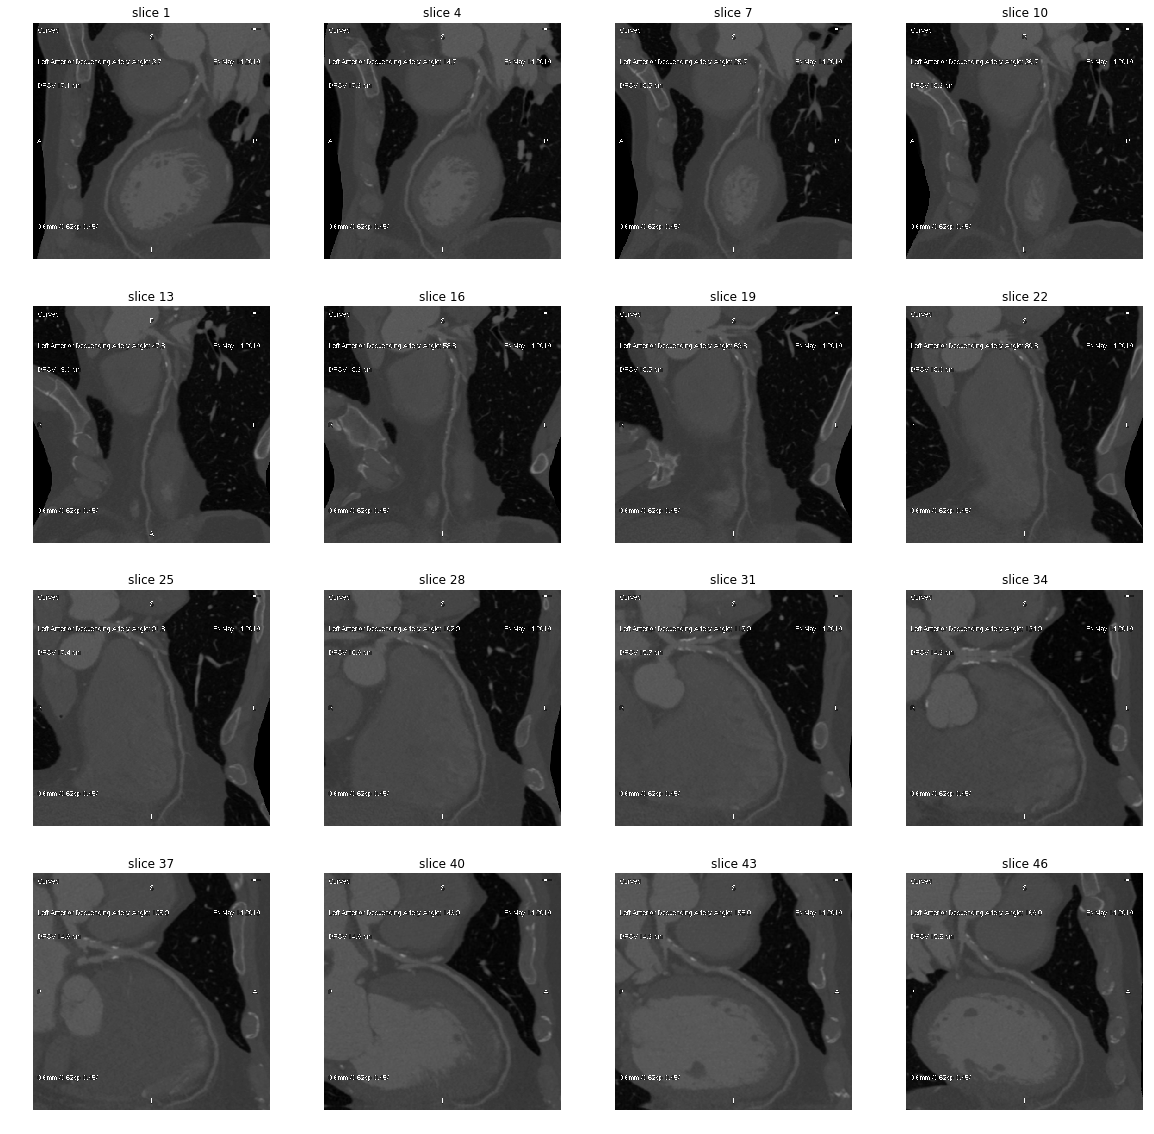

In [11]:
show_stack(get_pixels_hu(patient['LAD *']), rows=4, cols=4, start_with=1, show_every=3)

In [ ]:
['LAD-D1 *', 'LAD *', 'LAD-D2 *', 'LAD-D3 *', 'LAD - D4 *', 'LAD', 'LAD-D1', 'LAD-D2', 'LAD*', 'LAD-D1*', 
 'LAD-D2*', 'LAD - D1', 'LAD-D3', 'LIMA-LAD', 'LAD original', 'LAD-D1 original', 'LAD-D2 original', 
 'LAD-D3 original', 'LIMA-LAD graft', 'LAD-Branch of D1', 'LAD-D4', 'LAD Original', 'LAD-D1 Original', 
 'Aorta-LAD graft', 'LAD-D3*', 'LAD-Branch of D2 *', 'LAD TO PDA *', 'PDA TO LAD *', 'LAD-D4 *']

In [4]:
path_to_the_patient = r'D:\coronaryProject\dataset\binary_classification_MPR\images\327 CTCAARD10111950'

pat_dict = get_patient_dictionary(path_to_the_patient)